In [1]:
import time
from collections import deque

# -------- Image processing -----
import pyautogui
import numpy as np
import cv2
import mss

# -------- TensorFlow / Keras ----
import tensorflow as tf
from tensorflow.keras import layers, Model

# -------- Misc / Debug ----------
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

print("All imports successful for Run3 project!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")


All imports successful for Run3 project!
TensorFlow version: 2.15.0
NumPy version: 1.26.4
OpenCV version: 4.10.0


In [2]:
#Establish some variables and params for later

#number of frames to feed model at a time. We input to the model the FRAME_STACK most recent frames
FRAME_STACK = 4

#variables for the location of the run 3 game on the screen. This is for Malcolms computer, if its diff for u make new vars
TOP_X = 275
TOP_Y = 195
WIDTH = 725
HEIGHT = 545

GAMEOVER_X = 860
GAMEOVER_Y = 435
GAMEOVER_W = 70
GAMEOVER_H = 45

RUNWAY_X = 600
RUNWAY_Y = 480
RUNWAY_W = 75
RUNWAY_H = 180

#Which device is running the game. Add ur own if u wanna train. So we dont have to go all the way through everything and change
MAC_LAPTOP = True 
MAC_MONITOR = False

if MAC_LAPTOP: 
    TOP_X = 275
    TOP_Y = 195
    WIDTH = 725
    HEIGHT = 545

    GAMEOVER_X = 860
    GAMEOVER_Y = 435
    GAMEOVER_W = 70
    GAMEOVER_H = 45

    RUNWAY_X = 625
    RUNWAY_Y = 450
    RUNWAY_W = 75
    RUNWAY_H = 140


#resolution of the image were resizing to. This affects the input to our neural net directly.
RESOLUTION = 96

#number of actions the model can take. This is a super important thing to change if the model isnt training well. As of 12/5 were starting
#with the model being able to take [no action, L_small, R_small, U_small, L_med, R_med ...etc.]
NUM_ACTIONS = 10


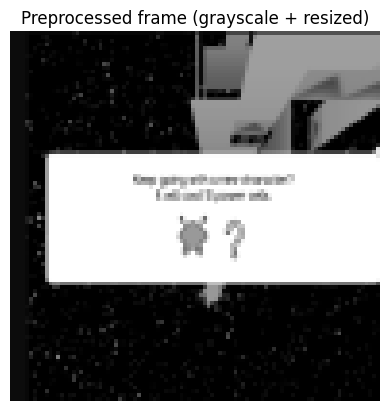

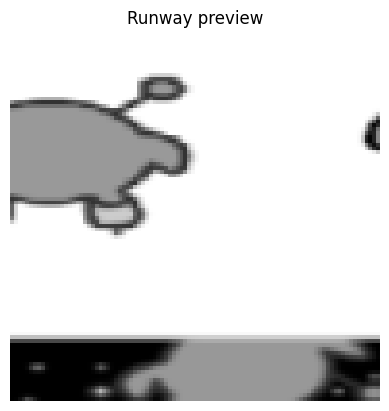

In [3]:
def preprocess_frame(image, resize=(RESOLUTION, RESOLUTION), gray=True):
    """
    Captures a screenshot of the given region, converts to grayscale, resizes.
    Returns numpy array of shape (resize[1], resize[0]).
    """
    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize deterministically
    small = cv2.resize(image, resize, interpolation=cv2.INTER_AREA)
    
    return small

def stack_frames(frames, new_frame, stack_size=FRAME_STACK):
    """
    Maintains a stack of frames to capture motion.
    frames: deque of previous frames
    new_frame: newest preprocessed frame
    Returns stack of frames
    """
    if len(frames) == 0:
        # Initialize with repeated frame
        for _ in range(stack_size):
            frames.append(new_frame)
    else:
        frames.append(new_frame)
        if len(frames) > stack_size:
            frames.popleft()
    return np.stack(frames, axis=0)

#TEST to see if screen grab is working

time.sleep(3)

sct = mss.mss()
monitor = {
    "top": TOP_Y,
    "left": TOP_X,
    "width": WIDTH,
    "height": HEIGHT
}
runway = {
    "top": RUNWAY_Y,
    "left": RUNWAY_X,
    "width": RUNWAY_W,
    "height": RUNWAY_H
}
screenshot = np.array(sct.grab(monitor))
img = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGRA2BGR)
processed = preprocess_frame(img)
plt.imshow(processed, cmap="gray")
plt.title("Preprocessed frame (grayscale + resized)")
plt.axis("off")
plt.show()

screenshot = np.array(sct.grab(runway))
img = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGRA2BGR)
processed = preprocess_frame(img)
plt.imshow(processed, cmap="gray")
plt.title("Runway preview")
plt.axis("off")
plt.show()

In [4]:
class PPOActorCritic(tf.keras.Model):
    def __init__(self, input_channels=FRAME_STACK, num_actions=NUM_ACTIONS):
        super(PPOActorCritic, self).__init__()

        # TensorFlow expects channels-last → (RESOLUTION, RESOLUTION, C)
        self.input_channels = input_channels
        self.num_actions = num_actions
        
        # ---------- CNN Backbone ----------
        self.conv1 = layers.Conv2D(32, kernel_size=8, strides=4, activation='relu')
        self.conv2 = layers.Conv2D(64, kernel_size=4, strides=2, activation='relu')
        self.conv3 = layers.Conv2D(64, kernel_size=3, strides=1, activation='relu')

        #max pool? think about max pool if we use a larger resolution. But these convs also scale down.

        # compute flatten size
        self._conv_out_size = self._get_conv_out((RESOLUTION, RESOLUTION, input_channels))

        # ---------- Shared Fully Connected ----------
        self.fc = layers.Dense(512, activation='relu')

        # ---------- Actor Head ----------
        self.actor_fc1 = layers.Dense(64, activation='relu')
        self.actor_logits = layers.Dense(num_actions, activation=None)

        # ---------- Critic Head ----------
        self.critic_fc1 = layers.Dense(64, activation='relu')
        self.critic_value = layers.Dense(1, activation=None)

    # -------------------------------------------------
    # Compute conv output size by running dummy tensor. This saves us work if we change the CNN structure
    # -------------------------------------------------
    def _get_conv_out(self, shape):
        dummy = tf.zeros((1, *shape), dtype=tf.float32)
        x = self.conv1(dummy)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(np.prod(x.shape[1:]))

    # -------------------------------------------------
    # Forward pass
    # -------------------------------------------------
    def call(self, x):
        """
        x expected as (batch, RESOLUTION, RESOLUTION, 4)
        """
        x = tf.cast(x, tf.float32) / 255.0 #normalize to [0,1]

        # CNN backbone
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten
        x = tf.reshape(x, (x.shape[0], -1))

        # Shared FC
        x = self.fc(x)

        # ---- Actor ----
        a = self.actor_fc1(x)
        logits = self.actor_logits(a)

        # ---- Critic ----
        c = self.critic_fc1(x)
        value = self.critic_value(c)

        return logits, value

In [5]:
class Run3Env:
    def __init__(self, region=(TOP_X, TOP_Y, WIDTH, HEIGHT), frame_stack=FRAME_STACK):
        self.region = region
        self.frame_stack = frame_stack #integer, not the actual stack. Do we need instance var?
        self.frames = deque(maxlen=frame_stack)

        self.sct = mss.mss()
        self.monitor = {
            "top": region[1],      # TOP_Y
            "left": region[0],     # TOP_X
            "width": region[2],    # WIDTH
            "height": region[3]    # HEIGHT
        }
        self.prev_platform_score = 0.0

    # -------------------------
    # Reset environment
    # -------------------------
    def reset(self):
        # Click to restart game. 900,650 is just off the screen a bit, click twice to bypass the "continue" and "score". 
        #we can also press a button to make it better for everyones computer
        time.sleep(.7)
        pyautogui.click(900, 650)
        time.sleep(.7)
        pyautogui.click(900, 650)
        self.frames.clear()

        # Get initial observation
        raw = self.capture_raw()
        processed = preprocess_frame(raw) #function defined at the top
        stacked = stack_frames(self.frames, processed)
        
        self.prev_platform_score = self.runway_reward(raw)

        return np.transpose(stacked, (1, 2, 0))  # (RESOLUTION, RESOLUTION, FRAME_STACK). 

    # -------------------------
    # Capture raw screenshot
    # -------------------------
    def capture_raw(self):
        screenshot = np.array(self.sct.grab(self.monitor))
        # mss returns BGRA, convert to BGR. Also mss is much faster than pyautogui so we use it for more fps.
        img = cv2.cvtColor(screenshot, cv2.COLOR_BGRA2BGR)
        return img

    # -------------------------
    # Detect game over
    # -------------------------
    def game_over(self, raw_frame): #FIX
        """Check if dialog region is white"""
        # Extract region. Note hard coded values are for macs laptop, its a region of the screen where its all white on game over.
        tlx = GAMEOVER_X - TOP_X
        tly = GAMEOVER_Y - TOP_Y
        w = GAMEOVER_W
        h = GAMEOVER_H
        roi = raw_frame[tly:tly+h, tlx:tlx+w]
        
        # Check if white directly on BGR image
        mean_val = roi.mean()  # Average across all pixels AND all channels
        
        # If all channels are ~255, mean will be ~255
        return mean_val > 250

    def runway_reward(self, raw_frame):
        tlx = RUNWAY_X - TOP_X
        tly = RUNWAY_Y - TOP_Y
        w = RUNWAY_W
        h = RUNWAY_H
        roi = raw_frame[tly:tly+h, tlx:tlx+w]

        if len(roi.shape) == 3: #grayscale
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        else:
            roi_gray = roi
        
        platform_pixels = np.sum(roi_gray > 30)
        total_pixels = roi_gray.size
        platform_ratio = platform_pixels / total_pixels
        
        return platform_ratio #small reward based on % of runway occupied.

    # -------------------------
    # Take one step in environment 
    # -------------------------
    def step(self, action): #NOT FINISHED DONT TOUCH
        # step_start = time.time()
        self._execute_action(action)

        # Capture new frame
        raw = self.capture_raw()

        done = self.game_over(raw) #Boolean var
        
        platform_score = self.runway_reward(raw)

        # Change in platform score since last step, but clamp to avoid huge spikes
        raw_delta = platform_score - self.prev_platform_score
        delta_platform = np.clip(raw_delta, -0.05, 0.05)
        self.prev_platform_score = platform_score

        # Reward logic
        if done:
            reward = -10.0
        else:
            # Only reward improvements + small per-step time penalty
            progress_reward = max(delta_platform, 0.0) * 5.0   # tweak 3.0 as needed
            time_penalty = -0.005                               # cost per step to discourage camping

            reward = progress_reward + time_penalty

            # keep a small penalty for 'no action' if you like
            if action == 0:
                reward -= 0.02

        # Preprocess
        processed = preprocess_frame(raw)
        stacked = stack_frames(self.frames, processed)
        
        state = np.transpose(stacked, (1, 2, 0))  # (REOSLUTION,RESOLUTION,STACK_FRAMES)

        # TARGET_TIMESTEP = 0.33 
        # elapsed = time.time() - step_start
        # if elapsed < TARGET_TIMESTEP:
        #     time.sleep(TARGET_TIMESTEP - elapsed)

        return state, reward, done, {}

    def _execute_action(self, action):
        """Execute action with proper hold durations"""
        # Map actions to (key, duration_seconds)
        action_config = {
            0: (None, 0),           # No action
            1: ('left', 0.05),       # Left short - 100ms
            2: ('right', 0.05),      # Right short
            3: ('up', 0.05),         # Up short (jump)
            4: ('left', 0.1),      # Left medium - 250ms
            5: ('right', 0.1),     # Right medium
            6: ('up', 0.1),        # Up medium
            7: ('left', 0.25),       # Left long - 500ms
            8: ('right', 0.25),      # Right long
            9: ('up', 0.25),         # Up long
        }
        
        key, duration = action_config[action]
        
        if key is not None:
            pyautogui.keyDown(key)
            time.sleep(duration)
            pyautogui.keyUp(key)
        pause = max(0.0, 0.25 - duration)
        time.sleep(pause)

In [92]:
# #JUST FOR TESTING THINGS WORK WHEN RUNNING THE GAME.
# sct = mss.mss()
# monitor = {
#     "top": TOP_Y,
#     "left": TOP_X,
#     "width": WIDTH,
#     "height": HEIGHT
# }
# num_g_over = 0

# def test_game_over(raw_frame):
#     """Check if dialog region is white"""
#     # Extract region
#     tlx = 860 - TOP_X
#     tly = 435 - TOP_Y
#     w = 70
#     h = 45
#     roi = raw_frame[tly:tly+h, tlx:tlx+w]
    
#     # Check if white directly on BGR image
#     mean_val = roi.mean()  # Average across all pixels AND all channels
    
#     # If all channels are ~255, mean will be ~255
#     return mean_val > 250

# def test_runway_reward(raw_frame):
#     tlx = RUNWAY_X - TOP_X
#     tly = RUNWAY_Y - TOP_Y
#     w = RUNWAY_W
#     h = RUNWAY_H
#     roi = raw_frame[tly:tly+h, tlx:tlx+w]

#     if len(roi.shape) == 3: #grayscale
#         roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
#     else:
#         roi_gray = roid
    
#     platform_pixels = np.sum(roi_gray > 30)
#     total_pixels = roi_gray.size
#     platform_ratio = platform_pixels / total_pixels
    
#     return platform_ratio

# while True:
#     start_time = time.time()
#     screenshot = np.array(sct.grab(monitor))
#     img = cv2.cvtColor(screenshot, cv2.COLOR_BGRA2BGR)
#     if test_game_over(img):
#         num_g_over += 1
#         print(f"\rgame over {num_g_over}", end='', flush=True)
#         time.sleep(0.7)
#         pyautogui.click(900, 650)
#         time.sleep(0.7)
#         pyautogui.click(900, 650)
#     else:
#         pass
#         # print(test_runway_reward(img))
#     elapsed = time.time() - start_time
#     if elapsed < 1:
#             time.sleep(1 - elapsed)


In [6]:
#IHAVENT CHECKED THE CLASS BELOW YET THIS IS JUST CHAT SO DONT TREAT IT AS SOLIDLY IMPLEMENTED

class PPOBuffer:
    def __init__(self, size, obs_shape, gamma=0.99, lam=0.95):
        """
        size      : number of steps per rollout
        obs_shape : shape of observation e.g. (RESOLUTION, RESOLUTION, FRAME_STACK)
        gamma     : discount factor
        lam       : GAE lambda
        """
        self.size = size
        self.gamma = gamma
        self.lam = lam

        # Allocate buffers
        self.obs_buf = np.zeros((size, *obs_shape), dtype=np.float32)
        self.act_buf = np.zeros(size, dtype=np.int32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)

        # To be computed later
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)

        self.ptr = 0        # next index to write
        self.path_start = 0 # start index of current trajectory

    # ---------------------------------------------------------
    # Store one step of rollout data
    # ---------------------------------------------------------
    def store(self, obs, act, rew, done, val, logp):
        assert self.ptr < self.size, "PPOBuffer overflow!"
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    # ---------------------------------------------------------
    # Finish trajectory and compute GAE + returns
    # last_val is the value of the final observation (0 if done)
    # ---------------------------------------------------------
    def finish_trajectory(self, last_val=0):
        """
        Called at trajectory end or when episode completes.
        Computes GAE advantage & discounted returns.
        """
        i1 = self.path_start
        i2 = self.ptr

        rewards = np.append(self.rew_buf[i1:i2], last_val)
        values  = np.append(self.val_buf[i1:i2], last_val)

        # GAE-Lambda advantage calculation
        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        adv = np.zeros_like(deltas)
        last_gae = 0
        for t in reversed(range(len(deltas))):
            last_gae = deltas[t] + self.gamma * self.lam * last_gae * (1 - self.done_buf[i1 + t])
            adv[t] = last_gae

        self.adv_buf[i1:i2] = adv
        self.ret_buf[i1:i2] = adv + self.val_buf[i1:i2]

        self.path_start = self.ptr  # next trajectory starts here

    # ---------------------------------------------------------
    # Retrieve all data, normalize adv, and reset pointer
    # ---------------------------------------------------------
    def prepare_for_training(self):
        """
        Call this after all trajectories are collected and before get().
        Normalizes advantages across the entire buffer.
        """
        assert self.ptr == self.size, "Buffer not full!"
    
        # Normalize advantages
        adv_mean = self.adv_buf.mean()
        adv_std = self.adv_buf.std() + 1e-8
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std

        
    def get(self, batch_size=64):
        """Returns batches of rollout data."""
        assert self.ptr == self.size, "Buffer not full!"
    
        return {
            'obs': self.obs_buf,
            'act': self.act_buf,
            'adv': self.adv_buf,
            'ret': self.ret_buf,
            'logp': self.logp_buf,
            'val': self.val_buf
        }
    
    def reset(self):
        """
        Reset buffer for next rollout collection.
        Call this after training is done for the epoch.
        """
        self.ptr = 0
        self.path_start = 0

In [7]:
# ============================================================================
# TRAINING CONFIGURATION AND HYPERPARAMETERS
# ============================================================================

# Training hyperparameters
LEARNING_RATE = 3e-4
CLIP_RATIO = 0.2
VALUE_COEF = 0.5
ENTROPY_COEF = 0.03
MAX_GRAD_NORM = 0.5

# Rollout parameters
STEPS_PER_EPOCH = 1024  # Number of steps per training epoch
TRAIN_EPOCHS = 150      # Total number of epochs
MINI_BATCH_SIZE = 64    # Size of mini-batches for SGD
UPDATE_EPOCHS = 5      # Number of epochs to train on each batch

# Discount and GAE
GAMMA = 0.99
GAE_LAMBDA = 0.95

# Logging and checkpointing
LOG_INTERVAL = 3          # Log every N epochs
SAVE_INTERVAL = 25         # Save model every N epochs
EVAL_EPISODES = 10          # Number of episodes for evaluation

# Create directories for saving
import os
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('logs', exist_ok=True)

print("Training Configuration:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Steps per Epoch: {STEPS_PER_EPOCH}")
print(f"  Total Epochs: {TRAIN_EPOCHS}")
print(f"  Gamma: {GAMMA}, GAE Lambda: {GAE_LAMBDA}")
print(f"  Clip Ratio: {CLIP_RATIO}")

Training Configuration:
  Learning Rate: 0.0003
  Steps per Epoch: 1024
  Total Epochs: 150
  Gamma: 0.99, GAE Lambda: 0.95
  Clip Ratio: 0.2


In [8]:
# ============================================================================
# PPO TRAINING FUNCTIONS
# ============================================================================

def compute_loss(model, obs, actions, advantages, returns, old_log_probs, old_values):
    """
    Compute PPO loss with clipping.
    
    Args:
        model: PPOActorCritic model
        obs: observations (batch_size, H, W, C)
        actions: actions taken (batch_size,)
        advantages: advantage estimates (batch_size,)
        returns: discounted returns (batch_size,)
        old_log_probs: old action log probabilities (batch_size,)
        old_values: old value estimates (batch_size,)
    
    Returns:
        total_loss, policy_loss, value_loss, entropy
    """
    # Get current policy and value predictions
    logits, values = model(obs, training=True)
    values = tf.squeeze(values, axis=-1)
    
    # Compute log probabilities of actions
    action_dist = tf.compat.v1.distributions.Categorical(logits=logits)
    log_probs = action_dist.log_prob(actions)
    
    # Compute entropy for exploration bonus
    entropy = tf.reduce_mean(action_dist.entropy())
    
    # Compute ratio for PPO
    ratio = tf.exp(log_probs - old_log_probs)
    
    
    # Policy loss with clipping
    policy_loss_1 = -advantages * ratio
    policy_loss_2 = -advantages * tf.clip_by_value(ratio, 1 - CLIP_RATIO, 1 + CLIP_RATIO)
    policy_loss = tf.reduce_mean(tf.maximum(policy_loss_1, policy_loss_2))
    
    # Value loss with clipping
    value_pred_clipped = old_values + tf.clip_by_value(
        values - old_values, -CLIP_RATIO, CLIP_RATIO
    )
    value_loss_1 = tf.square(returns - values)
    value_loss_2 = tf.square(returns - value_pred_clipped)
    value_loss = 0.5 * tf.reduce_mean(tf.maximum(value_loss_1, value_loss_2))
    
    # Total loss
    total_loss = policy_loss + VALUE_COEF * value_loss - ENTROPY_COEF * entropy
    
    return total_loss, policy_loss, value_loss, entropy


@tf.function
def train_step(model, optimizer, obs, actions, advantages, returns, old_log_probs, old_values):
    """
    Single training step with gradient computation.
    """
    with tf.GradientTape() as tape:
        total_loss, policy_loss, value_loss, entropy = compute_loss(
            model, obs, actions, advantages, returns, old_log_probs, old_values
        )
    
    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)
    
    # Clip gradients
    gradients, _ = tf.clip_by_global_norm(gradients, MAX_GRAD_NORM)
    
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return total_loss, policy_loss, value_loss, entropy


print("Training functions defined!")

Training functions defined!


In [9]:
# ============================================================================
# DATA COLLECTION FUNCTION
# ============================================================================

def collect_rollout(env, model, buffer, num_steps):
    """
    Collect trajectories by running the current policy in the environment.
    
    Args:
        env: Run3Env instance
        model: PPOActorCritic model
        buffer: PPOBuffer instance
        num_steps: number of steps to collect
    
    Returns:
        ep_returns: list of episode returns
        ep_lengths: list of episode lengths
    """
    buffer.reset()  # Clear the buffer
    
    ep_returns = []
    ep_lengths = []
    current_ep_return = 0
    current_ep_length = 0
    
    # Reset environment
    obs = env.reset()
    
    for step in range(num_steps):
        # Get action from policy
        # Get action from policy
        obs_tensor = tf.expand_dims(obs, axis=0)  # Add batch dimension
        logits, value = model(obs_tensor, training=False)

# Sample action from distribution (use logits, not probs!)
        action_dist = tf.compat.v1.distributions.Categorical(logits=logits)
        action_tensor = action_dist.sample()[0]
        action = action_tensor.numpy()
        log_prob = action_dist.log_prob(action_tensor).numpy()
        value = value.numpy()[0, 0]
        
        # Take action in environment
        next_obs, reward, done, info = env.step(action)
        
        # Store transition
        buffer.store(obs, action, reward, done, value, log_prob)
        
        current_ep_return += reward
        current_ep_length += 1
        
        obs = next_obs
        
        if done:
            # Episode finished
            buffer.finish_trajectory(0)  # Terminal state has value 0
            ep_returns.append(current_ep_return)
            ep_lengths.append(current_ep_length)
            
            # Reset for next episode
            obs = env.reset()
            current_ep_return = 0
            current_ep_length = 0
    
    # If we ended mid-episode, bootstrap the value
    if current_ep_length > 0:
        obs_tensor = tf.expand_dims(obs, axis=0)
        _, last_value = model(obs_tensor, training=False)
        buffer.finish_trajectory(last_value.numpy()[0, 0])
        ep_returns.append(current_ep_return)
        ep_lengths.append(current_ep_length)
    
    buffer.prepare_for_training()

    return ep_returns, ep_lengths


print("Rollout collection function defined!")

Rollout collection function defined!


In [10]:
# ============================================================================
# EVALUATION FUNCTION
# ============================================================================

def evaluate_policy(env, model, num_episodes=5):
    """
    Evaluate the current policy deterministically (greedy).
    
    Args:
        env: Run3Env instance
        model: PPOActorCritic model
        num_episodes: number of episodes to run
    
    Returns:
        mean_return: average episode return
        std_return: standard deviation of returns
        mean_length: average episode length
    """
    episode_returns = []
    episode_lengths = []
    
    for ep in range(num_episodes):
        obs = env.reset()
        done = False
        ep_return = 0
        ep_length = 0
        
        while not done:
            # Use greedy action (argmax)
            obs_tensor = tf.expand_dims(obs, axis=0)
            logits, _ = model(obs_tensor, training=False)
            action = tf.argmax(logits[0]).numpy()
            
            obs, reward, done, info = env.step(action)
            ep_return += reward
            ep_length += 1
            
            # Safety: break if episode too long
            if ep_length > 10000:
                break
        
        episode_returns.append(ep_return)
        episode_lengths.append(ep_length)
    
    return (
        np.mean(episode_returns),
        np.std(episode_returns),
        np.mean(episode_lengths)
    )


print("Evaluation function defined!")

Evaluation function defined!


In [11]:
# ============================================================================
# INITIALIZE TRAINING COMPONENTS
# ============================================================================

print("Initializing training components...")

env = Run3Env()
model = PPOActorCritic(input_channels=FRAME_STACK, num_actions=NUM_ACTIONS)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
buffer = PPOBuffer(
    size=STEPS_PER_EPOCH,
    obs_shape=(RESOLUTION, RESOLUTION, FRAME_STACK),
    gamma=GAMMA,
    lam=GAE_LAMBDA
)

# Build model by running a forward pass
dummy_obs = tf.random.normal((1, RESOLUTION, RESOLUTION, FRAME_STACK))
_ = model(dummy_obs)
print(f"Model initialized with {model.count_params():,} parameters")

# ---- Load checkpoint weights (optional) ----
CHECKPOINT_PATH = "checkpoints/model_ely_dec9_1AM_epoch_50.h5"  # <-- put your .h5 file here
try:
    model.load_weights(CHECKPOINT_PATH)
    print(f"Loaded weights from {CHECKPOINT_PATH}")
except Exception as e:
    print(f"Could not load checkpoint at {CHECKPOINT_PATH}: {e}")

# Training metrics
training_stats = {
    'epoch': [],
    'mean_return': [],
    'mean_length': [],
    'policy_loss': [],
    'value_loss': [],
    'entropy': [],
    'eval_return': [],
    'eval_std': []
}

print("\nStarting training...")
print("=" * 80)

Initializing training components...
Model initialized with 2,242,027 parameters
Loaded weights from checkpoints/model_ely_dec9_1AM_epoch_50.h5

Starting training...


In [14]:
import wandb
run_name = "run3_ppo_dec9_ely_explo_run_2"

wandb.init(
    project="run3-ppo",        # change to your project name
    name=run_name,
    config={
        "resolution": RESOLUTION,
        "frame_stack": FRAME_STACK,
        "learning_rate": LEARNING_RATE,
        "gamma": GAMMA,
        "gae_lambda": GAE_LAMBDA,
        "clip_ratio": CLIP_RATIO,
        "entropy_coef": ENTROPY_COEF,
        "steps_per_epoch": STEPS_PER_EPOCH,
        "train_epochs": TRAIN_EPOCHS,
    }, 
    reinit=True
)

# Optional: watch model weights/gradients


wandb: Currently logged in as: ely_brayboy (ely_brayboy-brown-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [ ]:
# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

for epoch in range(TRAIN_EPOCHS):
    
    epoch_start_time = time.time()
    
    # === 1. Collect rollout data ===
    ep_returns, ep_lengths = collect_rollout(env, model, buffer, STEPS_PER_EPOCH)
    
    mean_return = np.mean(ep_returns) if len(ep_returns) > 0 else 0
    mean_length = np.mean(ep_lengths) if len(ep_lengths) > 0 else 0
    
    # === 2. Get training data from buffer ===
    data = buffer.get()
    obs_buf = data['obs']
    act_buf = data['act']
    adv_buf = data['adv']
    ret_buf = data['ret']
    logp_buf = data['logp']
    val_buf = data['val']
    
    # === 3. Train on the collected data ===
    total_losses = []
    policy_losses = []
    value_losses = []
    entropies = []
    
    # Perform multiple epochs of training on the same batch
    for i in range(UPDATE_EPOCHS):
        # Shuffle indices
        indices = np.arange(len(obs_buf))
        np.random.shuffle(indices)
        
        # Train on mini-batches
        for start in range(0, len(obs_buf), MINI_BATCH_SIZE):
            end = start + MINI_BATCH_SIZE
            batch_idx = indices[start:end]
            
            batch_obs = tf.constant(obs_buf[batch_idx])
            batch_act = tf.constant(act_buf[batch_idx])
            batch_adv = tf.constant(adv_buf[batch_idx])
            batch_ret = tf.constant(ret_buf[batch_idx])
            batch_logp = tf.constant(logp_buf[batch_idx])
            batch_val = tf.constant(val_buf[batch_idx])
            
            # Perform gradient update
            total_loss, policy_loss, value_loss, entropy = train_step(
                model, optimizer, batch_obs, batch_act,
                batch_adv, batch_ret, batch_logp, batch_val
            )
            
            total_losses.append(total_loss.numpy())
            policy_losses.append(policy_loss.numpy())
            value_losses.append(value_loss.numpy())
            entropies.append(entropy.numpy())
    
    # === 4. Logging ===
    epoch_time = time.time() - epoch_start_time

    # NEW: precompute means once & init eval metrics
    mean_policy_loss = float(np.mean(policy_losses))
    mean_value_loss  = float(np.mean(value_losses))
    mean_entropy     = float(np.mean(entropies))
    eval_return = eval_std = eval_length = None  # NEW
    
    if (epoch + 1) % LOG_INTERVAL == 0:
        print(f"\nEpoch {epoch + 1}/{TRAIN_EPOCHS} ({epoch_time:.1f}s)")
        print(f"  Returns: {mean_return:.2f} | Lengths: {mean_length:.1f}")
        print(f"  Policy Loss: {np.mean(policy_losses):.4f}")
        print(f"  Value Loss: {np.mean(value_losses):.4f}")
        print(f"  Entropy: {np.mean(entropies):.4f}")
        
        # Periodic evaluation
        if (epoch + 1) % (LOG_INTERVAL * 5) == 0:
            eval_return, eval_std, eval_length = evaluate_policy(env, model, EVAL_EPISODES)
            print(f"  [EVAL] Return: {eval_return:.2f} ± {eval_std:.2f} | Length: {eval_length:.1f}")
            training_stats['eval_return'].append(eval_return)
            training_stats['eval_std'].append(eval_std)
    
    # Store metrics
    training_stats['epoch'].append(epoch + 1)
    training_stats['mean_return'].append(mean_return)
    training_stats['mean_length'].append(mean_length)
    training_stats['policy_loss'].append(mean_policy_loss)
    training_stats['value_loss'].append(mean_value_loss)
    training_stats['entropy'].append(mean_entropy)

        # NEW: log to Weights & Biases once per epoch
    log_dict = {
        "epoch": epoch + 1,
        "train_return": mean_return,
        "train_length": mean_length,
        "policy_loss": mean_policy_loss,
        "value_loss": mean_value_loss,
        "policy_entropy": mean_entropy,
        "epoch_time_sec": epoch_time,
    }
    if eval_return is not None:
        log_dict.update({
            "eval_return": eval_return,
            "eval_return_std": eval_std,
            "eval_length": eval_length,
        })
    wandb.log(log_dict)  # NEW
    
    # === 5. Save checkpoint ===
    if (epoch + 1) % SAVE_INTERVAL == 0:
        checkpoint_path = f'checkpoints/explo_run_2{epoch + 1}.h5'
        model.save_weights(checkpoint_path)
        print(f"  [SAVED] Checkpoint: {checkpoint_path}")
    


print("\n" + "=" * 80)
print("Training complete!")

wandb.finish()


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
Use `tf.random.categorical` instead.


Instructions for updating:
Use `tf.random.categorical` instead.
/var/folders/q_/y2tlnq4d3gl5gqxkc15y__ym0000gn/T/ipykernel_78206/1679292621.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp



Epoch 3/150 (669.9s)
  Returns: -9.13 | Lengths: 11.9
  Policy Loss: -0.0749
  Value Loss: 0.8564
  Entropy: 1.6539

Epoch 6/150 (652.4s)
  Returns: -9.06 | Lengths: 12.6
  Policy Loss: -0.0747
  Value Loss: 0.5350
  Entropy: 1.6578

Epoch 9/150 (668.9s)
  Returns: -9.12 | Lengths: 12.2
  Policy Loss: -0.0672
  Value Loss: 0.3802
  Entropy: 1.6813

Epoch 12/150 (656.3s)
  Returns: -9.09 | Lengths: 12.3
  Policy Loss: -0.0750
  Value Loss: 0.3542
  Entropy: 1.6460

Epoch 15/150 (636.0s)
  Returns: -8.99 | Lengths: 13.5
  Policy Loss: -0.0735
  Value Loss: 0.3675
  Entropy: 1.7053
  [EVAL] Return: -8.45 ± 1.79 | Length: 21.5

Epoch 18/150 (641.5s)
  Returns: -9.03 | Lengths: 12.8
  Policy Loss: -0.0736
  Value Loss: 0.3166
  Entropy: 1.7415

Epoch 21/150 (635.1s)
  Returns: -8.93 | Lengths: 13.7
  Policy Loss: -0.0787
  Value Loss: 0.3570
  Entropy: 1.7351

Epoch 24/150 (640.3s)
  Returns: -9.00 | Lengths: 13.3
  Policy Loss: -0.0853
  Value Loss: 0.3179
  Entropy: 1.6021
  [SAVED] Chec

KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x32c77f0d0>> (for post_run_cell), with arguments args (<ExecutionResult object at 17681ce90, execution_count=24 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 31b6dcb10, raw_cell="# ================================================.." transformed_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/elybrayboy/Desktop/csci1470-course/Run-3-Agent/run3.ipynb#X16sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionResetError: Connection lost

In [25]:
wandb.finish()

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x32c77f0d0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 32c7f42d0, raw_cell="wandb.finish()" transformed_cell="wandb.finish()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/elybrayboy/Desktop/csci1470-course/Run-3-Agent/run3.ipynb#X20sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x32c77f0d0>> (for post_run_cell), with arguments args (<ExecutionResult object at 331aff1d0, execution_count=25 error_before_exec=None error_in_exec=[Errno 32] Broken pipe info=<ExecutionInfo object at 32c7f42d0, raw_cell="wandb.finish()" transformed_cell="wandb.finish()
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/elybrayboy/Desktop/csci1470-course/Run-3-Agent/run3.ipynb#X20sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [13]:
#JUST FOR LOADING AND EVALUATING A MODEL

env = Run3Env()
model = PPOActorCritic(input_channels=FRAME_STACK, num_actions=NUM_ACTIONS)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
buffer = PPOBuffer(
    size=STEPS_PER_EPOCH,
    obs_shape=(RESOLUTION, RESOLUTION, FRAME_STACK),
    gamma=GAMMA,
    lam=GAE_LAMBDA
)

# Build model by running a forward pass
dummy_obs = tf.random.normal((1, RESOLUTION, RESOLUTION, FRAME_STACK))
_ = model(dummy_obs)
print(f"Model initialized with {model.count_params():,} parameters")

model_path = 'checkpoints/model_ely_dec9_1AM_epoch_50.h5'  # or whichever epoch you want
model.load_weights(model_path)
print(f"Loaded model from {model_path}")

eval_return, eval_std, eval_length = evaluate_policy(env, model, EVAL_EPISODES)
print(f"  [EVAL] Return: {eval_return:.2f} ± {eval_std:.2f} | Length: {eval_length:.1f}")
training_stats['eval_return'].append(eval_return)
training_stats['eval_std'].append(eval_std)

Model initialized with 2,242,027 parameters
Loaded model from checkpoints/model_ely_dec9_1AM_epoch_50.h5
  [EVAL] Return: -8.89 ± 0.82 | Length: 14.9
